## GEOM7001 Flood Mapping Before and After Cyclone Debbie - Sentinel- Imagery
This script lists the workflow for delineating flood inundation caused by Cyclone Debbie in March 2017 using SAR imagery
The workflow includes before and after images in both VV and VH polarizations.

### Upload ARD Sentinel-1 VH and VV Linear Gamma0 images Before and After Cyclone

In [42]:
import rasterio
import numpy as np

# --- VH file paths ---
vh_before_path = "20170314_S1_VH_linear_gamma0.tiff"
vh_after_path  = "20170407_S1_VH_linear_gamma0.tiff"

# --- VV file paths ---
vv_before_path = "20170314_S1_VV_linear_gamma0.tiff"
vv_after_path  = "20170407_S1_VV_linear_gamma0.tiff"

# --- Load VH rasters ---
with rasterio.open(vh_before_path) as src:
    vh_before = src.read(1)
    vh_meta = src.meta  # georeference info

with rasterio.open(vh_after_path) as src:
    vh_after = src.read(1)

# --- Load VV rasters ---
with rasterio.open(vv_before_path) as src:
    vv_before = src.read(1)
    vv_meta = src.meta  # georeference info

with rasterio.open(vv_after_path) as src:
    vv_after = src.read(1)


In [25]:
# # DO NOT USE - OPEN S2 TIFF TO USE TO RESAMPLE TO SENTINEL 2 IMAGES
# import rasterio

# with rasterio.open("s2_before_ref.tif") as s2_ref:
#     s2_meta = s2_ref.meta.copy()
#     s2_transform = s2_ref.transform
#     s2_width = s2_ref.width
#     s2_height = s2_ref.height


### Set queries for Bbox and Reproject to Australian Albers

In [43]:
from pyproj import Transformer

# Bounding box in WGS84
lon_min, lat_min, lon_max, lat_max = 150.41, -23.45, 150.55, -23.29

# Transformer from WGS84 → Australian Albers (EPSG:3577)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3577", always_xy=True)

x_min, y_min = transformer.transform(lon_min, lat_min)
x_max, y_max = transformer.transform(lon_max, lat_max)

bbox_albers = [x_min, y_min, x_max, y_max]


### Reproject images and crop to Bbox

In [27]:
# # DO NOT USE - resampled version to sentinel 2 so they align in pixels for comparison later
# import rasterio
# import numpy as np
# from rasterio.warp import reproject, Resampling

# def reproject_then_crop(src_path, dst_path, bbox_albers=None, resolution=10, dst_crs="EPSG:3577",
#                         reference_raster=None):
#     """
#     Reproject a raster to a specified CRS, optionally crop to a bounding box, or resample
#     to match a reference raster.

#     Parameters
#     ----------
#     src_path : str
#         Path to input raster.
#     dst_path : str
#         Path to save output raster.
#     bbox_albers : tuple, optional
#         Bounding box in target CRS: (x_min, y_min, x_max, y_max). Ignored if reference_raster is provided.
#     resolution : float
#         Target pixel size in meters. Ignored if reference_raster is provided.
#     dst_crs : str
#         Target CRS (default: Australian Albers EPSG:3577).
#     reference_raster : str, optional
#         Path to reference raster (e.g., Sentinel-2) to match size, transform, and CRS.
#     """
#     if reference_raster is not None:
#         with rasterio.open(reference_raster) as ref:
#             transform_new = ref.transform
#             width = ref.width
#             height = ref.height
#             dst_crs = ref.crs
#     elif bbox_albers is not None:
#         x_min, y_min, x_max, y_max = bbox_albers
#         width  = int((x_max - x_min) / resolution)
#         height = int((y_max - y_min) / resolution)
#         from rasterio.transform import from_origin
#         transform_new = from_origin(x_min, y_max, resolution, resolution)
#     else:
#         raise ValueError("Either bbox_albers or reference_raster must be provided.")

#     with rasterio.open(src_path) as src:
#         meta = src.meta.copy()
#         meta.update({
#             "crs": dst_crs,
#             "transform": transform_new,
#             "width": width,
#             "height": height
#         })

#         reprojected = np.empty((height, width), dtype=src.dtypes[0])

#         reproject(
#             source=rasterio.band(src, 1),
#             destination=reprojected,
#             src_transform=src.transform,
#             src_crs=src.crs,
#             dst_transform=transform_new,
#             dst_crs=dst_crs,
#             resampling=Resampling.nearest
#         )

#         with rasterio.open(dst_path, "w", **meta) as dst:
#             dst.write(reprojected, 1)


In [44]:
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_origin

def reproject_then_crop(src_path, dst_path, bbox_albers, resolution=10, dst_crs="EPSG:3577"):
    """
    Reproject a raster to a specified CRS, crop to a bounding box, and
    enforce a fixed resolution so all outputs have the same size.

    Parameters
    ----------
    src_path : str
        Path to input raster.
    dst_path : str
        Path to save output raster.
    bbox_albers : tuple
        Bounding box in target CRS: (x_min, y_min, x_max, y_max)
    resolution : float
        Target pixel size in meters.
    dst_crs : str
        Target CRS (default: Australian Albers EPSG:3577).
    """
    x_min, y_min, x_max, y_max = bbox_albers

    # Compute output width/height
    width  = int((x_max - x_min) / resolution)
    height = int((y_max - y_min) / resolution)

    # Define target transform
    transform_new = from_origin(x_min, y_max, resolution, resolution)

    with rasterio.open(src_path) as src:
        meta = src.meta.copy()
        meta.update({
            "crs": dst_crs,
            "transform": transform_new,
            "width": width,
            "height": height
        })

        # Prepare output array
        reprojected = np.empty((height, width), dtype=src.dtypes[0])

        # Reproject + resample to match target grid
        reproject(
            source=rasterio.band(src, 1),
            destination=reprojected,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform_new,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

        # Save
        with rasterio.open(dst_path, "w", **meta) as dst:
            dst.write(reprojected, 1)


### Write in reprojected and cropped images to files

In [28]:
# # DO NOT USE - resampled files to match sentinel 2
# reproject_then_crop("20170314_S1_VH_linear_gamma0.tiff", "vh_before_resampled_to_s2.tif", reference_raster="s2_before_ref.tif")
# reproject_then_crop("20170407_S1_VH_linear_gamma0.tiff", "vh_after_resampled_to_s2.tif", reference_raster="s2_before_ref.tif")
# reproject_then_crop("20170314_S1_VV_linear_gamma0.tiff", "vv_before_resampled_to_s2.tif", reference_raster="s2_before_ref.tif")
# reproject_then_crop("20170407_S1_VV_linear_gamma0.tiff", "vv_after_resampled_to_s2.tif", reference_raster="s2_before_ref.tif")


In [45]:
reproject_then_crop("20170314_S1_VH_linear_gamma0.tiff", "vh_linear_before_albers_cropped.tif", bbox_albers)
reproject_then_crop("20170407_S1_VH_linear_gamma0.tiff", "vh_linear_after_albers_cropped.tif", bbox_albers)
reproject_then_crop("20170314_S1_VV_linear_gamma0.tiff", "vv_linear_before_albers_cropped.tif", bbox_albers)
reproject_then_crop("20170407_S1_VV_linear_gamma0.tiff", "vv_linear_after_albers_cropped.tif", bbox_albers)

In [46]:
print(vh_before.shape, vh_after.shape, vv_before.shape, vv_after.shape)

(2500, 2296) (2500, 2296) (2500, 2296) (2500, 2296)


In [40]:
# # DO NOT USE
# import rasterio
# import matplotlib.pyplot as plt

# # --- SAR ---
# with rasterio.open("vh_before_resampled_to_s2.tif") as src:
#     sar = src.read(1)
#     sar_transform = src.transform
#     sar_crs = src.crs

# # --- Sentinel-2 (e.g., Red band you saved as tif) ---
# with rasterio.open("s2_B4_time0.tif") as src:
#     s2_band = src.read(1)
#     s2_transform = src.transform
#     s2_crs = src.crs

# # --- Check metadata ---
# print("Shapes:", sar.shape, s2_band.shape)
# print("Transforms equal?", sar_transform == s2_transform)
# print("CRS equal?", sar_crs == s2_crs)

# # --- Overlay plot ---
# plt.figure(figsize=(8,8))
# plt.imshow(s2_band, cmap="Greys_r", alpha=0.6)
# plt.imshow(sar, cmap="Reds", alpha=0.4)
# plt.title("SAR over Sentinel-2 (alignment check)")
# plt.show()


### Stack images

In [38]:
# # DO NOT USE - Resampled version
# import numpy as np
# import matplotlib.pyplot as plt
# import rasterio

# # --- File paths (resampled to Sentinel-2) ---
# vh_before_path = "vh_before_resampled_to_s2.tif"
# vh_after_path  = "vh_after_resampled_to_s2.tif"
# vv_before_path = "vv_before_resampled_to_s2.tif"
# vv_after_path  = "vv_after_resampled_to_s2.tif"

# # --- Function to read raster ---
# def read_raster(path):
#     with rasterio.open(path) as src:
#         arr = src.read(1)
#     return arr

# # --- Read all images ---
# vh_before = read_raster(vh_before_path)
# vh_after  = read_raster(vh_after_path)
# vv_before = read_raster(vv_before_path)
# vv_after  = read_raster(vv_after_path)

# # --- Stack images ---
# name = np.stack([vh_before, vh_after, vv_before, vv_after], axis=0)
# names = ["VH Before", "VH After", "VV Before", "VV After"]


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# --- File paths ---
vh_before_path = "vh_linear_before_albers_cropped.tif"
vh_after_path  = "vh_linear_after_albers_cropped.tif"
vv_before_path = "vv_linear_before_albers_cropped.tif"
vv_after_path  = "vv_linear_after_albers_cropped.tif"

# --- Function to read raster ---
def read_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1)
    return arr

# --- Read all images ---
vh_before = read_raster(vh_before_path)
vh_after  = read_raster(vh_after_path)
vv_before = read_raster(vv_before_path)
vv_after  = read_raster(vv_after_path)

# --- Stack images ---
name = np.stack([vh_before, vh_after, vv_before, vv_after], axis=0)
names = ["VH Before", "VH After", "VV Before", "VV After"]

### Apply Lee filter then convert DN to dB

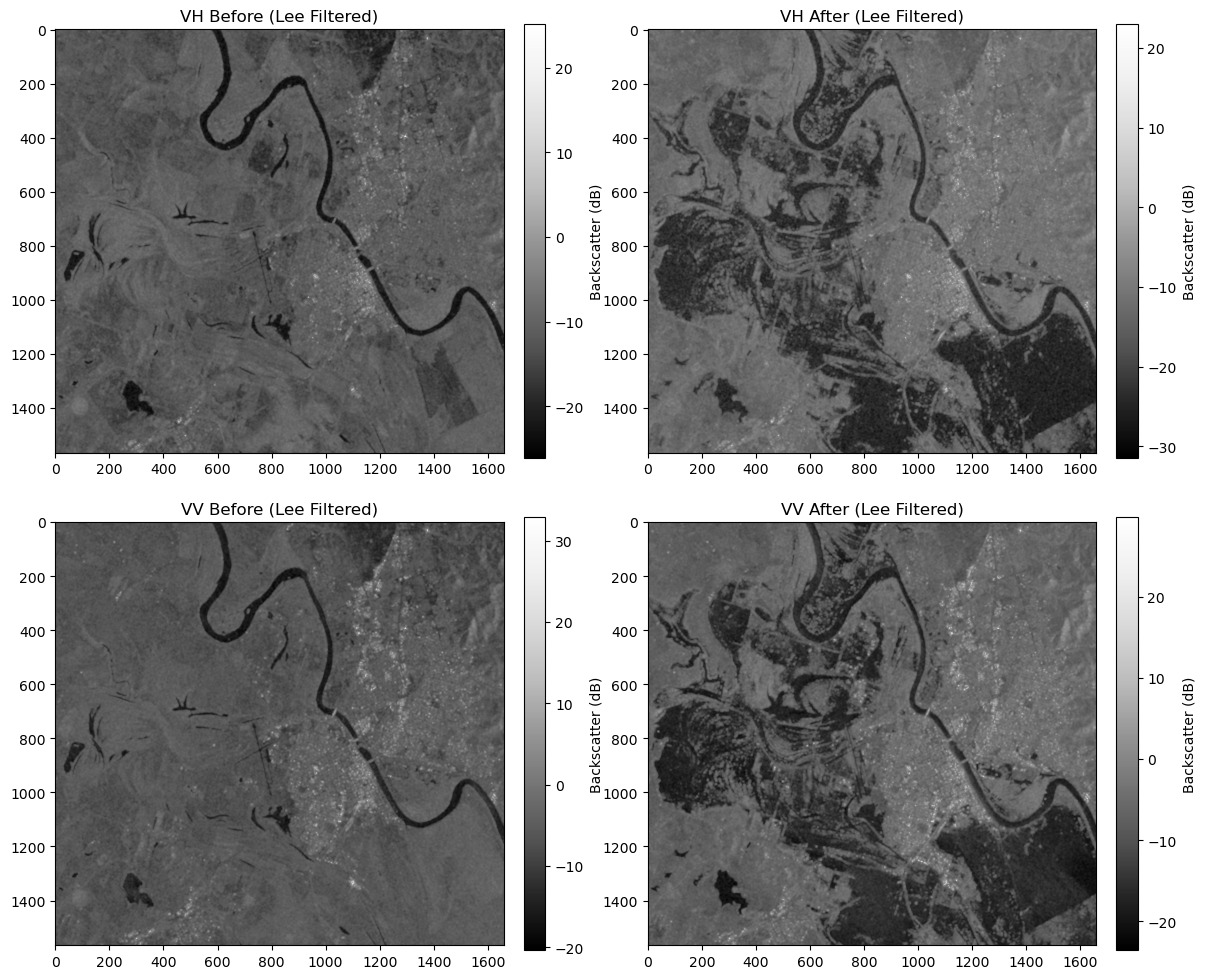

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

# --- Lee filter function ---
def lee_filter(img, size):
    """
    Applies the Lee filter to reduce speckle noise in an image (linear scale).

    Parameters:
    img (ndarray): Input image to be filtered (linear scale).
    size (int): Size of the uniform filter window.

    Returns:
    ndarray: The filtered image.
    """
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = np.var(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

# --- Parameters ---
window_size = 7       # Lee filter window
eps = 1e-4            # Tiny value to avoid log10(0)
names = ["VH Before", "VH After", "VV Before", "VV After"]

# --- Initialize lists for original and filtered images in dB ---
all_images_dB = []
filtered_stack_dB = []

# --- Loop through all images ---
for i in range(name.shape[0]):
    # Convert original DN to dB
    orig_dB = 10 * np.log10(name[i] + eps)
    all_images_dB.append(orig_dB)

    # Apply Lee filter in linear space, then convert to dB
    filtered_linear = lee_filter(name[i], size=window_size)
    filtered_dB = 10 * np.log10(filtered_linear + eps)
    filtered_stack_dB.append(filtered_dB)

# Stack filtered images for convenience
filtered_stack_dB = np.stack(filtered_stack_dB, axis=0)

# --- Plot filtered dB images ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, img, title in zip(axes.flatten(), filtered_stack_dB, names):
    cmap = plt.cm.Greys_r.copy()
    cmap.set_bad(color='black')  # handle NaNs if any
    im = ax.imshow(img, cmap=cmap)
    ax.set_title(f"{title} (Lee Filtered)")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Backscatter (dB)")

plt.tight_layout()
plt.show()


### DO NOT USE - Apply Refined Lee Filter for comparison

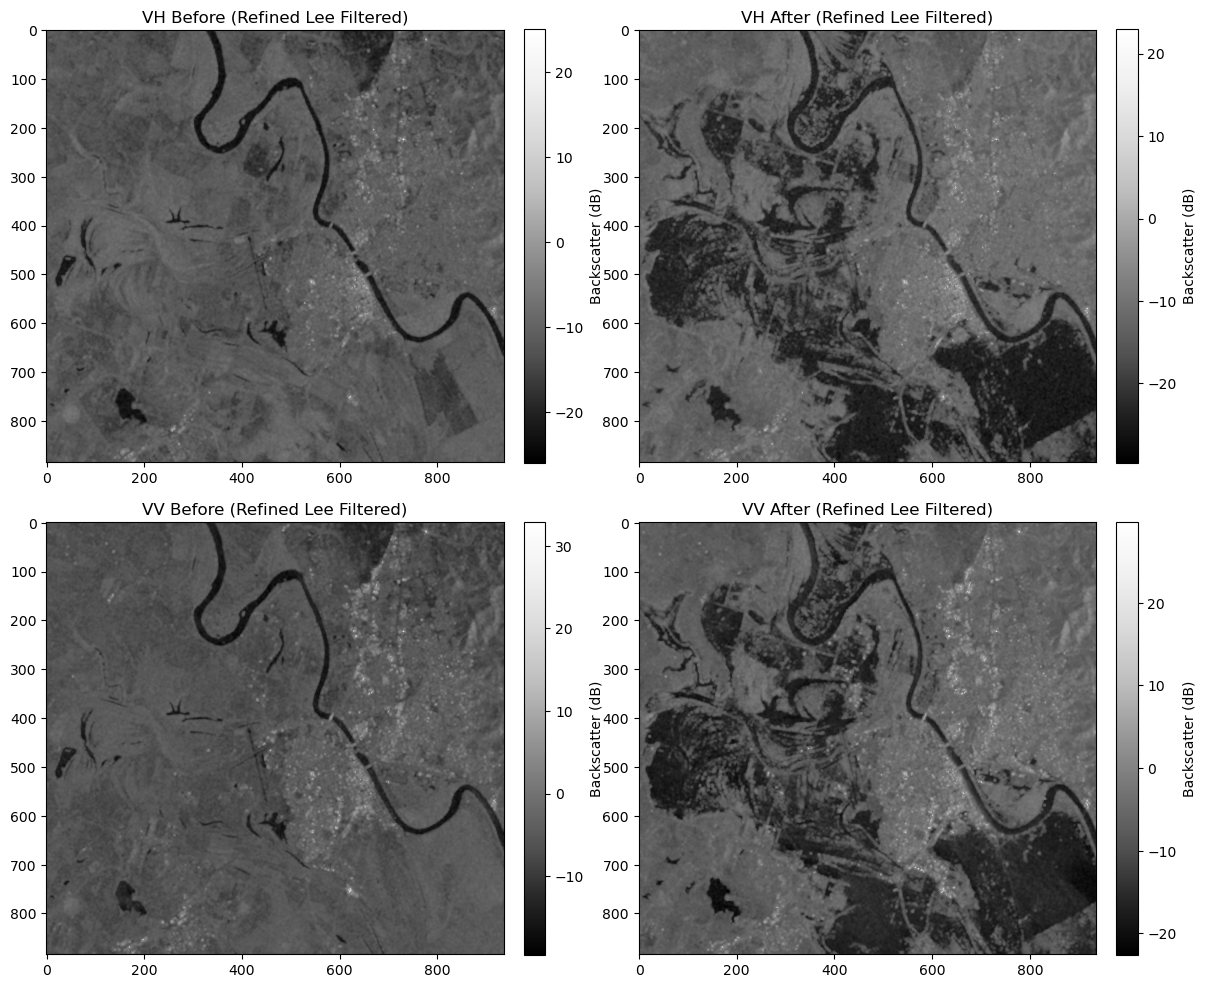

In [140]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import uniform_filter

# # --- Refined Lee filter function ---
# def refined_lee_filter(img, size):
#     """
#     Applies the Refined Lee filter to reduce speckle noise in a SAR image.

#     Parameters:
#     # img (ndarray): Input image to be filtered (linear scale).
#     size (int): Size of the uniform filter window.

#     Returns:
#     ndarray: Filtered image
#     """
#     img = img.astype(float)
    
#     # Local mean and variance
#     local_mean = uniform_filter(img, size=size)
#     local_sqr_mean = uniform_filter(img**2, size=size)
#     local_var = local_sqr_mean - local_mean**2

#     # Noise variance estimate
#     overall_var = np.var(img)

#     # Weighting factor
#     w = np.clip(local_var - overall_var, 0, None) / (local_var + 1e-10)
    
#     # Refined output
#     img_filtered = local_mean + w * (img - local_mean)
    
#     return img_filtered

# # --- Parameters ---
# window_size = 5       # Refined Lee filter window
# eps = 1e-4            # Tiny value to avoid log10(0)
# names = ["VH Before", "VH After", "VV Before", "VV After"]

# # --- Apply Refined Lee filter in linear space, then convert to dB ---
# filtered_stack_dB = []
# for i in range(name.shape[0]):
#     # Apply Refined Lee filter in linear space
#     filtered_linear = refined_lee_filter(name[i], size=window_size)
    
#     # Convert filtered result to dB
#     filtered_dB = 10 * np.log10(filtered_linear + eps)
#     filtered_stack_dB.append(filtered_dB)

# # Stack back into array
# filtered_stack_dB = np.stack(filtered_stack_dB, axis=0)

# # --- Plot filtered dB images ---
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# for ax, img, title in zip(axes.flatten(), filtered_stack_dB, names):
#     cmap = plt.cm.Greys_r.copy()
#     cmap.set_bad(color='black')  # handle NaNs if any
#     im = ax.imshow(img, cmap=cmap)
#     ax.set_title(f"{title} (Refined Lee Filtered)")
#     cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     cbar.set_label("Backscatter (dB)")

# plt.tight_layout()
# plt.show()


### DO NOT USE - Convert Lee filtered image Digital Numbers (DN) to dB & Visualise

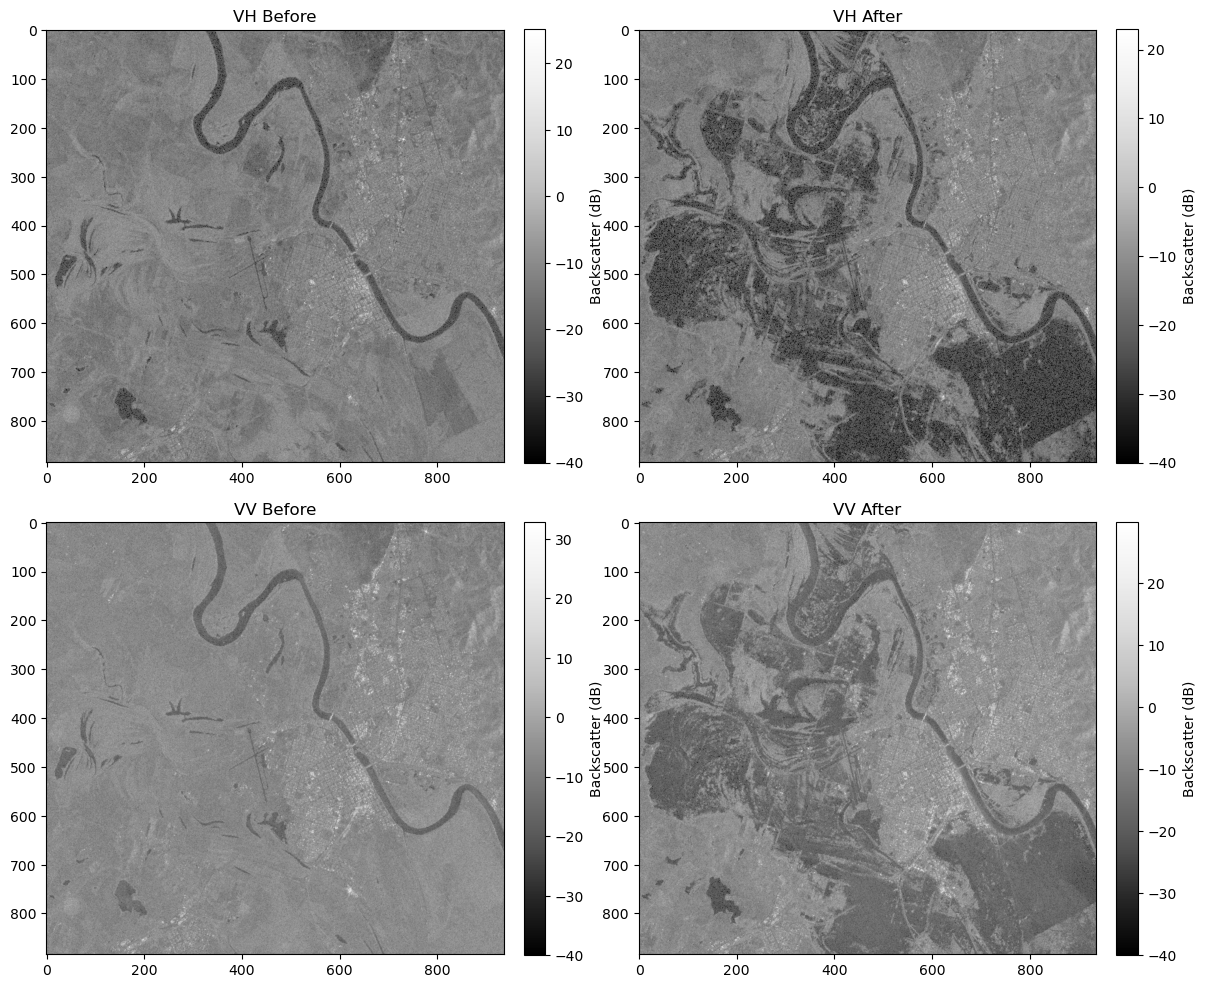

In [137]:
# # --- Function to convert linear to dB ---
# def dB_scale_safe(name, eps=1e-4):
#     """
#     Convert linear gamma0 to dB.
#     Replaces negative values with NaN, adds small epsilon to zero values to avoid -inf.
#     """
#     safe_data = np.where(name >= 0, name, np.nan)  # negative -> NaN
#     return 10 * np.log10(safe_data + eps)


# # --- Convert stacked images to dB ---
# all_images_dB = dB_scale_safe(name)

# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# names = ["VH Before", "VH After", "VV Before", "VV After"]

# for ax, img, title in zip(axes.flatten(), all_images_dB, names):
#     cmap = plt.cm.Greys_r.copy()
#     cmap.set_bad(color='black')  # now only true negative or nodata are black
#     im = ax.imshow(img, cmap=cmap)
#     ax.set_title(title)
#     cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     cbar.set_label("Backscatter (dB)")

# plt.tight_layout()
# plt.show()


### DO NOT USE - Apply Lee filter

In [76]:
# #APPLY LEE FILTER 
# # Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
# import numpy as np
# from scipy.ndimage import uniform_filter

# def lee_filter(img, size):
#     """
#     Applies the Lee filter to reduce speckle noise in an image.

#     Parameters:
#     img (ndarray): Input image to be filtered.
#     size (int): Size of the uniform filter window.

#     Returns:
#     ndarray: The filtered image.
#     """
#     img_mean = uniform_filter(img, size)
#     img_sqr_mean = uniform_filter(img**2, size)
#     img_variance = img_sqr_mean - img_mean**2

#     overall_variance = np.var(img)

#     img_weights = img_variance / (img_variance + overall_variance)
#     img_output = img_mean + img_weights * (img - img_mean)
#     return img_output


In [77]:
# # Define a function to apply the Lee filter to a DataArray
# # 'name' = stacked linear images (shape: 4, height, width)
# # 'names' = ["VH Before", "VH After", "VV Before", "VV After"]

# window_size = 7  # same as in your xarray example
# filtered_stack_dB = []

# eps = 1e-4  # tiny value to avoid log10(0)

# for i in range(name.shape[0]):
#     # Apply Lee filter in linear space
#     filtered_linear = lee_filter(name[i], size=window_size)
    
#     # Convert to dB
#     filtered_dB = 10 * np.log10(filtered_linear + eps)
    
#     filtered_stack_dB.append(filtered_dB)

# # Stack back into array
# filtered_stack_dB = np.stack(filtered_stack_dB, axis=0)


### DO NOT USE - Visualise Filtered images

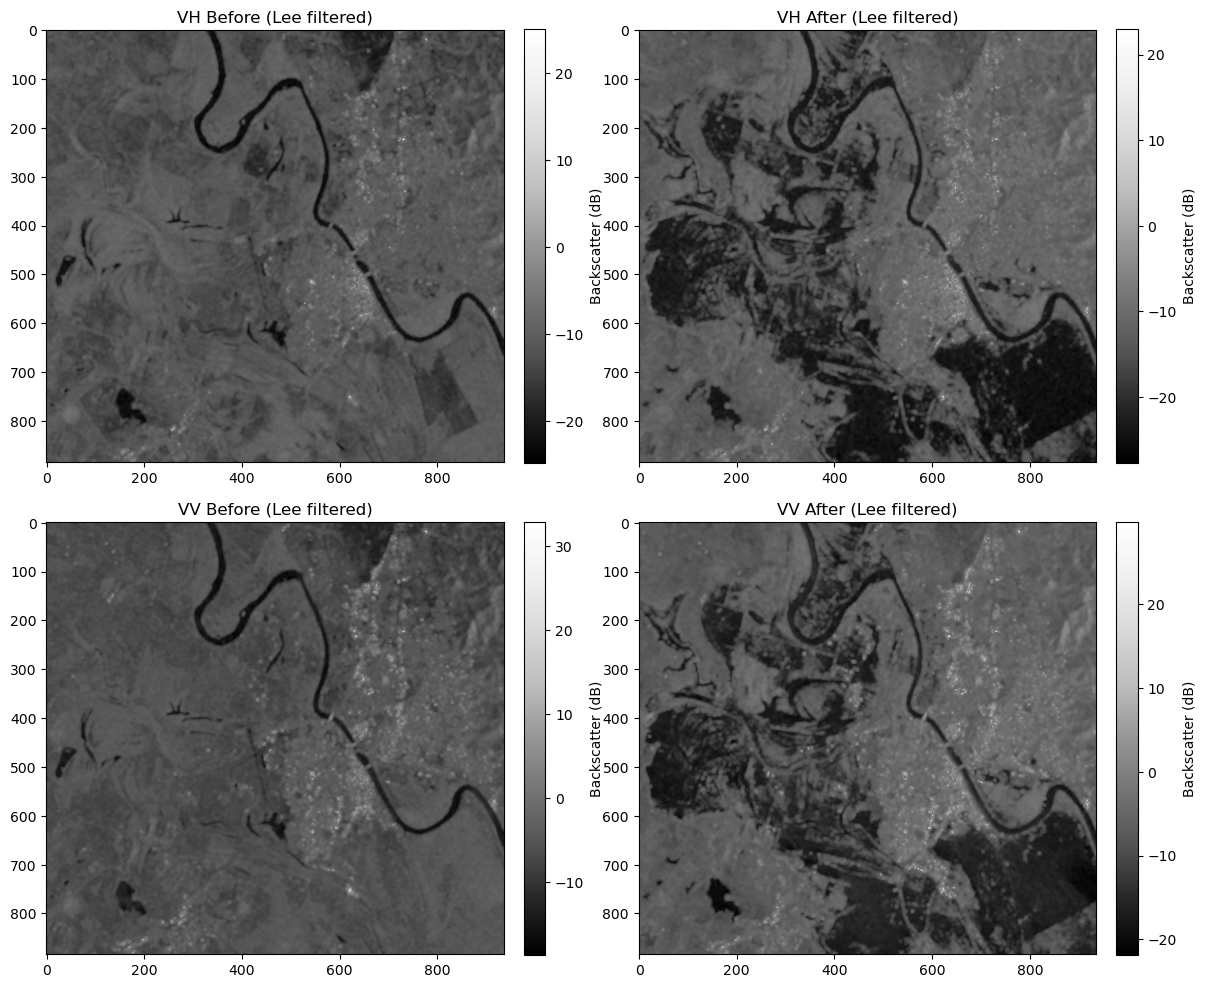

In [147]:
# # Visualise Lee Filter
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# for ax, img, title in zip(axes.flatten(), filtered_stack_dB, names):
#     cmap = plt.cm.Greys_r.copy()
#     cmap.set_bad(color='black')  # nan values appear black
#     im = ax.imshow(img, cmap=cmap)
#     ax.set_title(f"{title} (Lee filtered)")
#     cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     cbar.set_label("Backscatter (dB)")

# plt.tight_layout()
# plt.show()


### Plot histograms to see the effects of Lee filtering on VH and VV images

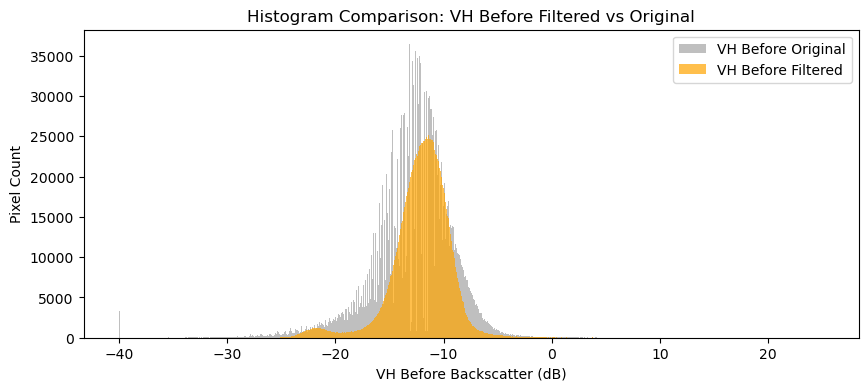

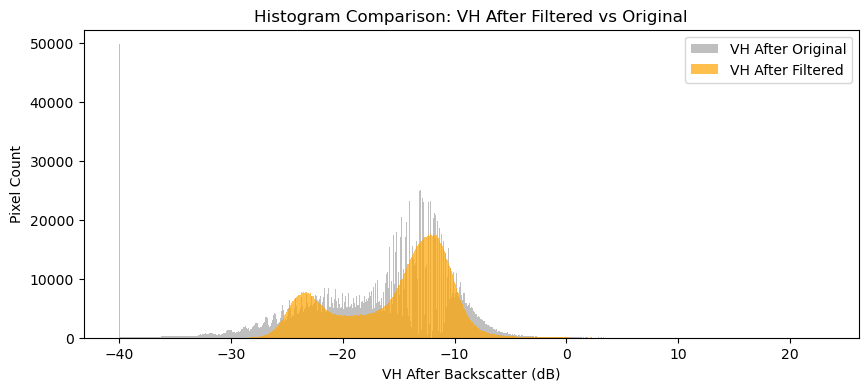

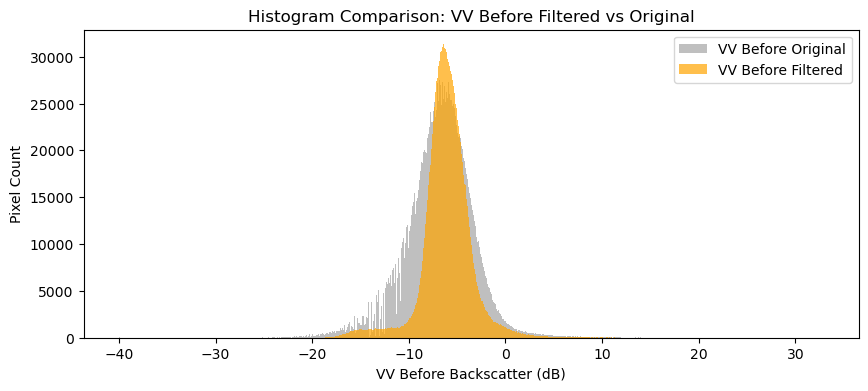

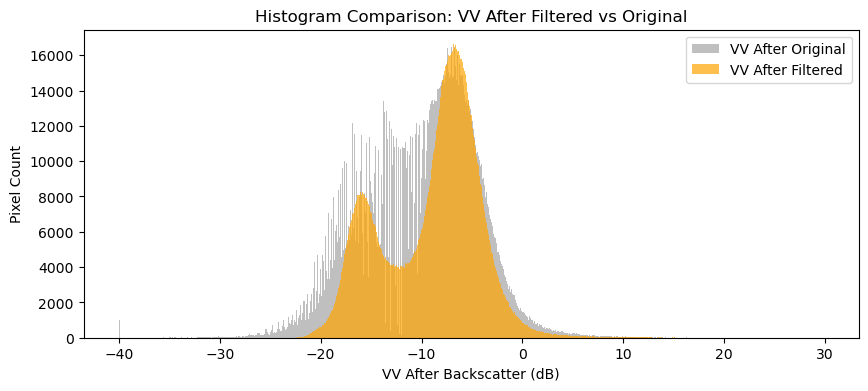

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# all_images_dB = original stacked images in dB (from dB_scale_safe)
# filtered_stack_dB = Lee-filtered images in dB
# names = ["VH Before", "VH After", "VV Before", "VV After"]

for i, title in enumerate(names):
    orig = all_images_dB[i]
    filt = filtered_stack_dB[i]

    # Mask invalid pixels (0 or NaN)
    mask_orig = (~np.isnan(orig)) & (orig != 0)
    mask_filt = (~np.isnan(filt)) & (filt != 0)

    # Compute histograms to scale y-axis
    orig_hist, _ = np.histogram(orig[mask_orig].ravel(), bins=1000)
    filt_hist, _ = np.histogram(filt[mask_filt].ravel(), bins=1000)
    max_count = max(orig_hist.max(), filt_hist.max())

    # Plot histogram
    plt.figure(figsize=(10, 4))
    plt.hist(orig[mask_orig].ravel(), bins=1000, alpha=0.5, label=f"{title} Original", color='gray')
    plt.hist(filt[mask_filt].ravel(), bins=1000, alpha=0.7, label=f"{title} Filtered", color='orange')
    plt.xlabel(f"{title} Backscatter (dB)")
    plt.ylabel("Pixel Count")
    plt.title(f"Histogram Comparison: {title} Filtered vs Original")
    plt.ylim(0, max_count*1.05)
    plt.legend()
    plt.show()

### Stack by VH and VV

In [70]:
vh_stack_filtered_dB = filtered_stack_dB[0:2]
vv_stack_filtered_dB = filtered_stack_dB[2:4]

### Visually define threshold for filtered VH and VV
Using threshold values derived from literature: Manjusree et al. 2021 & Sajid et al. 2025

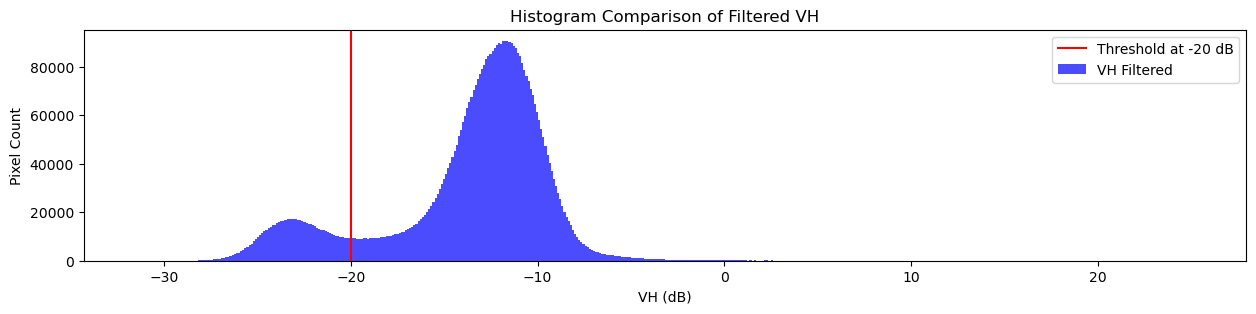

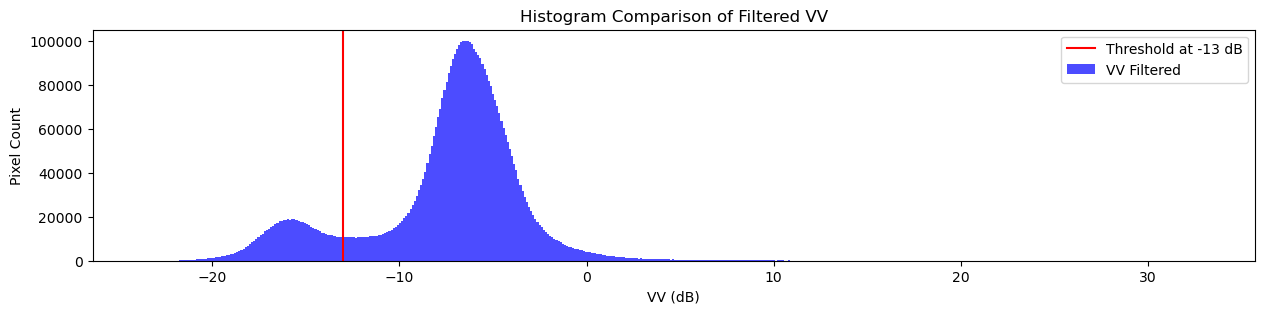

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for plotting (example: -15 dB, adjust as needed)
vh_threshold = -20
vv_threshold = -13

# --- VH Histogram ---
fig = plt.figure(figsize=(15, 3))
plt.axvline(x=vh_threshold, label=f"Threshold at {vh_threshold} dB", color="red")

plt.hist(vh_stack_filtered_dB.ravel(), bins=500, alpha=0.7, label="VH Filtered", color="blue")

plt.legend()
plt.xlabel("VH (dB)")
plt.ylabel("Pixel Count")
plt.title("Histogram Comparison of Filtered VH")
plt.show()

# --- VV Histogram ---
fig = plt.figure(figsize=(15, 3))
plt.axvline(x=vv_threshold, label=f"Threshold at {vv_threshold} dB", color="red")

plt.hist(vv_stack_filtered_dB.ravel(), bins=500, alpha=0.7, label="VV Filtered", color="blue")

plt.legend()
plt.xlabel("VV (dB)")
plt.ylabel("Pixel Count")
plt.title("Histogram Comparison of Filtered VV")
plt.show()


### Apply Otsu thresholding method for more accuracy

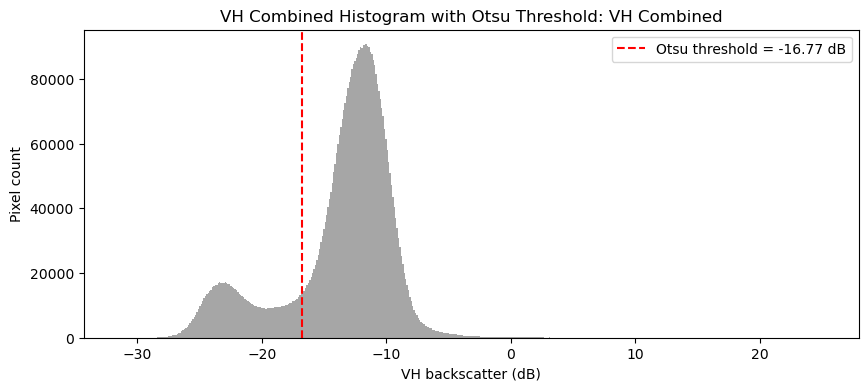

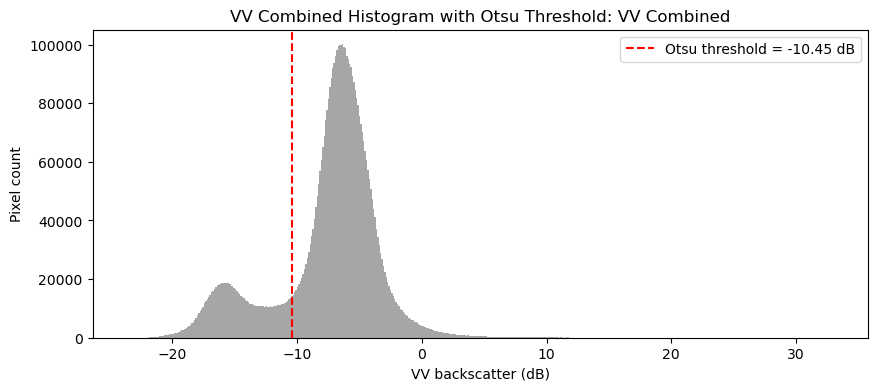

VH combined threshold: -16.771769
VV combined threshold: -10.449282


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

# --- Unstack filtered images ---
vh_before_filt_dB, vh_after_filt_dB, vv_before_filt_dB, vv_after_filt_dB = filtered_stack_dB

# --- Function to apply Otsu threshold on combined data and plot ---
def otsu_threshold_plot_combined(img_list, label, band="VH"):
    # Stack the images into 1D array, mask NaN/zeros
    combined_data = np.concatenate([img[np.isfinite(img)][img[np.isfinite(img)] != 0] for img in img_list])
    
    # Compute Otsu threshold
    threshold = threshold_otsu(combined_data)
    
    # Plot histogram with threshold line
    plt.figure(figsize=(10,4))
    plt.hist(combined_data.ravel(), bins=500, color="gray", alpha=0.7)
    plt.axvline(threshold, color="red", linestyle="--", label=f"Otsu threshold = {threshold:.2f} dB")
    plt.xlabel(f"{band} backscatter (dB)")
    plt.ylabel("Pixel count")
    plt.title(f"{band} Combined Histogram with Otsu Threshold: {label}")
    plt.legend()
    plt.show()
    
    return threshold

# --- Run for VH (combined before+after) ---
vh_threshold = otsu_threshold_plot_combined([vh_before_filt_dB, vh_after_filt_dB], label="VH Combined", band="VH")

# --- Run for VV (combined before+after) ---
vv_threshold = otsu_threshold_plot_combined([vv_before_filt_dB, vv_after_filt_dB], label="VV Combined", band="VV")

print("VH combined threshold:", vh_threshold)
print("VV combined threshold:", vv_threshold)

In [73]:
# Update thresholds for VH and VV
vh_threshold_otsu = -16.622353
vv_threshold_otsu = -10.204561

### Defining water and non-water from Otsu thresholds for VH and VV

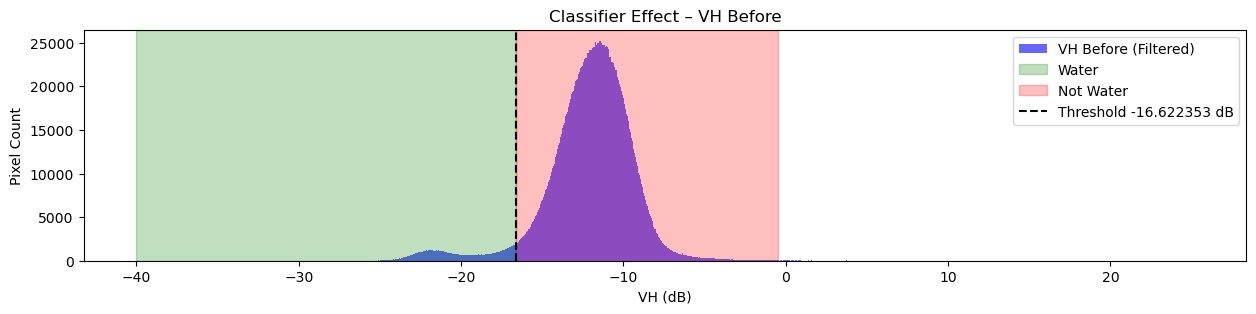

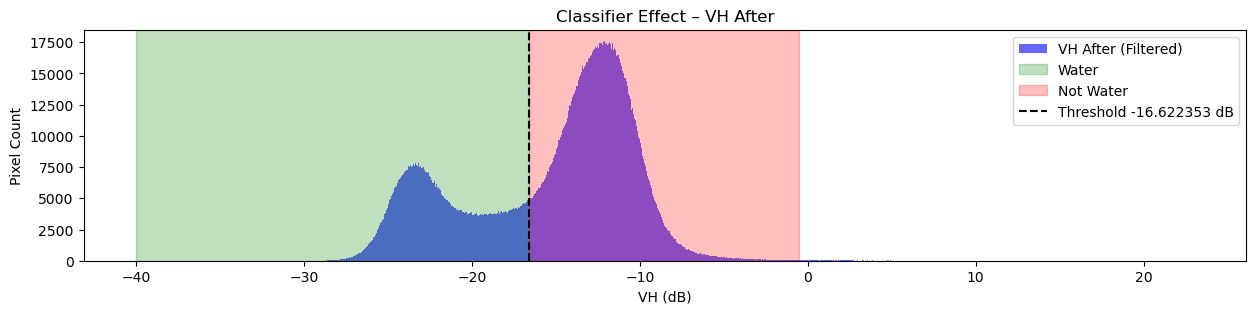

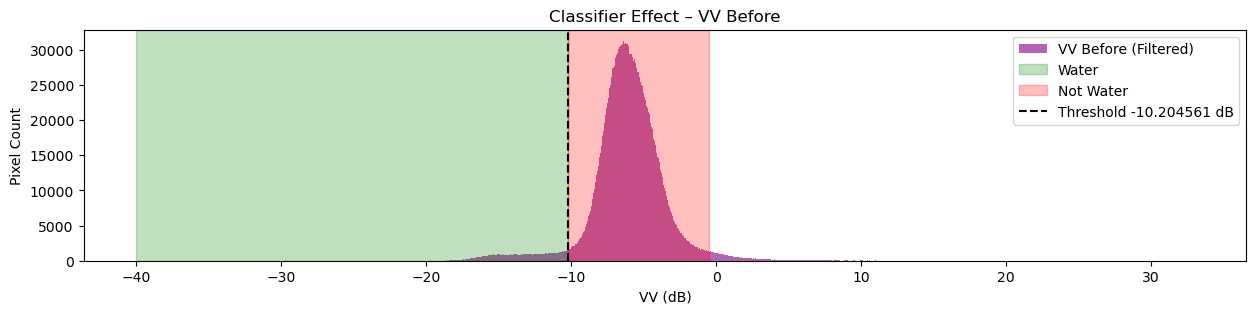

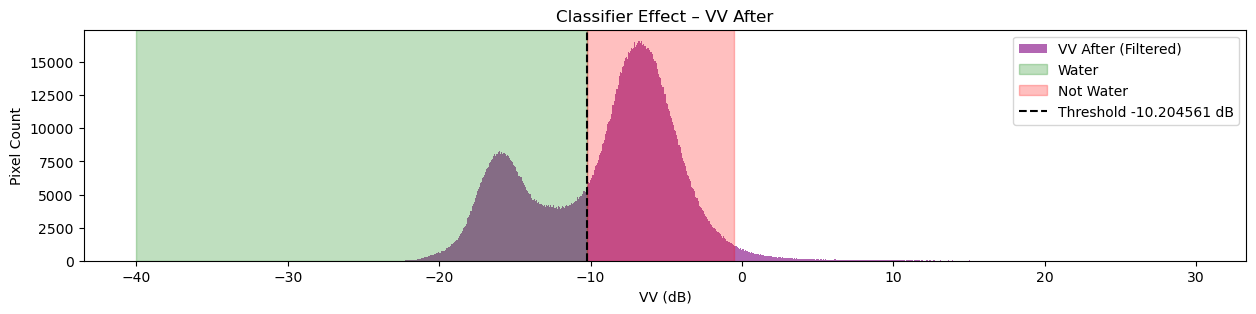

In [74]:
import matplotlib.pyplot as plt

# Unstack your filtered arrays (assuming axis=0 is [VH_before, VH_after, VV_before, VV_after])
vh_before_filt, vh_after_filt, vv_before_filt, vv_after_filt = filtered_stack_dB

# --- VH Before ---
fig, ax = plt.subplots(figsize=(15, 3))
ax.hist(vh_before_filt.ravel(), bins=1000, color="blue", alpha=0.6, label="VH Before (Filtered)")
ax.axvspan(-40.0, vh_threshold_otsu, alpha=0.25, color="green", label="Water")
ax.axvspan(vh_threshold_otsu, -0.5, alpha=0.25, color="red", label="Not Water")
ax.axvline(vh_threshold_otsu, color="black", linestyle="--", label=f"Threshold {vh_threshold_otsu} dB")
ax.set_xlabel("VH (dB)")
ax.set_ylabel("Pixel Count")
ax.set_title("Classifier Effect – VH Before")
ax.legend()
plt.show()

# --- VH After ---
fig, ax = plt.subplots(figsize=(15, 3))
ax.hist(vh_after_filt.ravel(), bins=1000, color="blue", alpha=0.6, label="VH After (Filtered)")
ax.axvspan(-40.0, vh_threshold_otsu, alpha=0.25, color="green", label="Water")
ax.axvspan(vh_threshold_otsu, -0.5, alpha=0.25, color="red", label="Not Water")
ax.axvline(vh_threshold_otsu, color="black", linestyle="--", label=f"Threshold {vh_threshold_otsu} dB")
ax.set_xlabel("VH (dB)")
ax.set_ylabel("Pixel Count")
ax.set_title("Classifier Effect – VH After")
ax.legend()
plt.show()

# --- VV Before ---
fig, ax = plt.subplots(figsize=(15, 3))
ax.hist(vv_before_filt.ravel(), bins=1000, color="purple", alpha=0.6, label="VV Before (Filtered)")
ax.axvspan(-40.0, vv_threshold_otsu, alpha=0.25, color="green", label="Water")
ax.axvspan(vv_threshold_otsu, -0.5, alpha=0.25, color="red", label="Not Water")
ax.axvline(vv_threshold_otsu, color="black", linestyle="--", label=f"Threshold {vv_threshold_otsu} dB")
ax.set_xlabel("VV (dB)")
ax.set_ylabel("Pixel Count")
ax.set_title("Classifier Effect – VV Before")
ax.legend()
plt.show()

# --- VV After ---
fig, ax = plt.subplots(figsize=(15, 3))
ax.hist(vv_after_filt.ravel(), bins=1000, color="purple", alpha=0.6, label="VV After (Filtered)")
ax.axvspan(-40.0, vv_threshold_otsu, alpha=0.25, color="green", label="Water")
ax.axvspan(vv_threshold_otsu, -0.5, alpha=0.25, color="red", label="Not Water")
ax.axvline(vv_threshold_otsu, color="black", linestyle="--", label=f"Threshold {vv_threshold_otsu} dB")
ax.set_xlabel("VV (dB)")
ax.set_ylabel("Pixel Count")
ax.set_title("Classifier Effect – VV After")
ax.legend()
plt.show()


### Build and apply Classifier

In [75]:
import numpy as np

def create_water_mask(filtered_dB, threshold):
    """
    Returns a binary water mask from a Lee-filtered dB image.
    1 = water
    0 = non-water
    NaN pixels remain NaN.
    """
    # Start with zeros
    mask = np.zeros_like(filtered_dB, dtype=np.uint8)
    
    # Set water pixels (below threshold) to 1
    mask[(filtered_dB < threshold) & np.isfinite(filtered_dB)] = 1
    
    # Optionally keep NaNs where input is NaN
    mask = mask.astype(np.uint8)
    
    return mask

# --- Apply thresholds ---
vh_before_mask = create_water_mask(vh_before_filt_dB, vh_threshold_otsu)
vh_after_mask  = create_water_mask(vh_after_filt_dB,  vh_threshold_otsu)
vv_before_mask = create_water_mask(vv_before_filt_dB, vv_threshold_otsu)
vv_after_mask  = create_water_mask(vv_after_filt_dB,  vv_threshold_otsu)

# Combine before + after for each polarization using logical OR
vh_combined = ((vh_before_mask | vh_after_mask)).astype(np.uint8)
vv_combined = ((vv_before_mask | vv_after_mask)).astype(np.uint8)

In [76]:
# Check VH and VV classifiers
vh_combined
vv_combined

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

### Visualise flood delineation
0 = Non-water
1 = Water

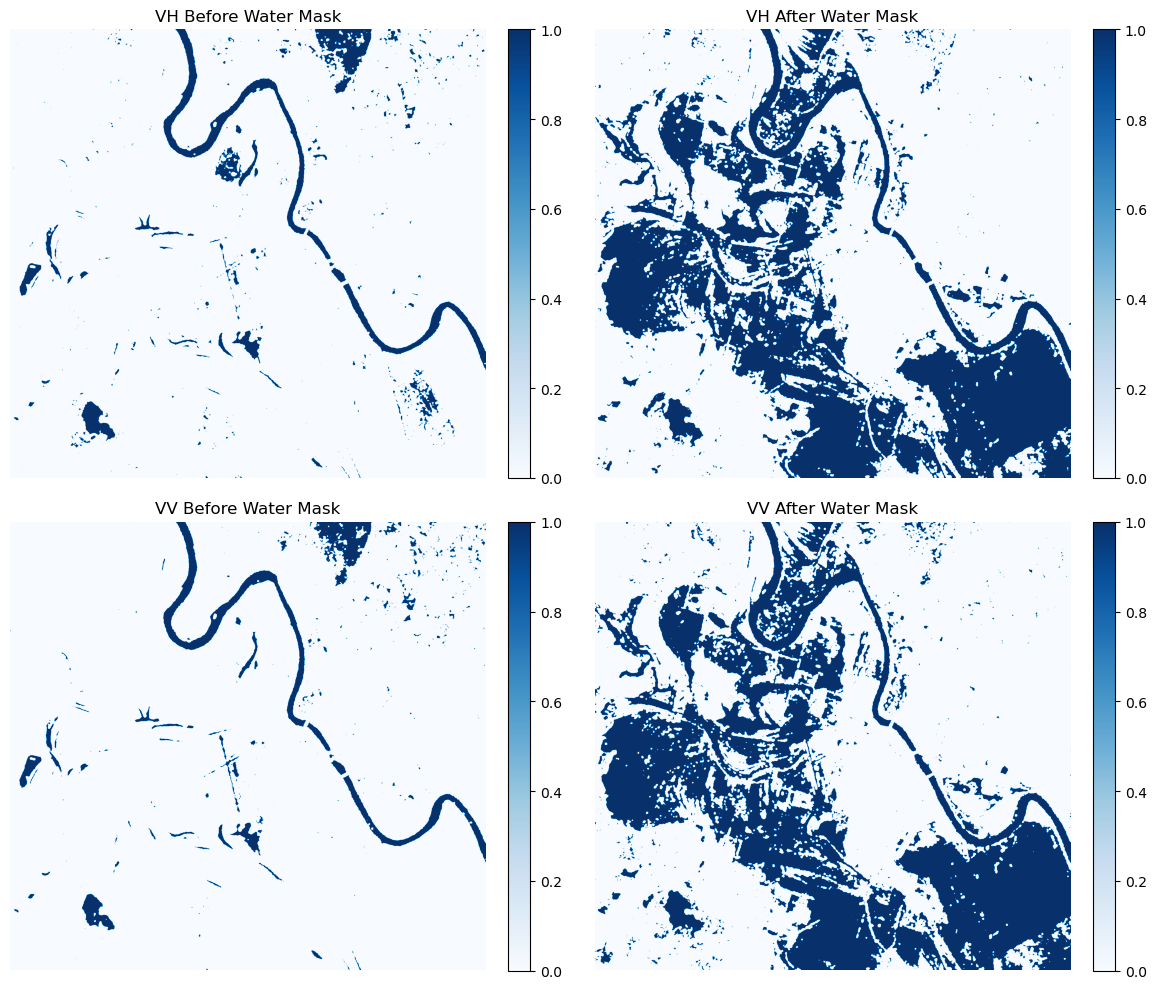

In [77]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- VH Before and After ---
im0 = axes[0, 0].imshow(vh_before_mask, cmap="Blues", vmin=0, vmax=1)
axes[0, 0].set_title("VH Before Water Mask")
axes[0, 0].axis("off")
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

im1 = axes[0, 1].imshow(vh_after_mask, cmap="Blues", vmin=0, vmax=1)
axes[0, 1].set_title("VH After Water Mask")
axes[0, 1].axis("off")
fig.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

# --- VV Before and After ---
im2 = axes[1, 0].imshow(vv_before_mask, cmap="Blues", vmin=0, vmax=1)
axes[1, 0].set_title("VV Before Water Mask")
axes[1, 0].axis("off")
fig.colorbar(im2, ax=axes[1, 0], fraction=0.046, pad=0.04)

im3 = axes[1, 1].imshow(vv_after_mask, cmap="Blues", vmin=0, vmax=1)
axes[1, 1].set_title("VV After Water Mask")
axes[1, 1].axis("off")
fig.colorbar(im3, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### Change detection between Before and After Cyclone for VV and VH

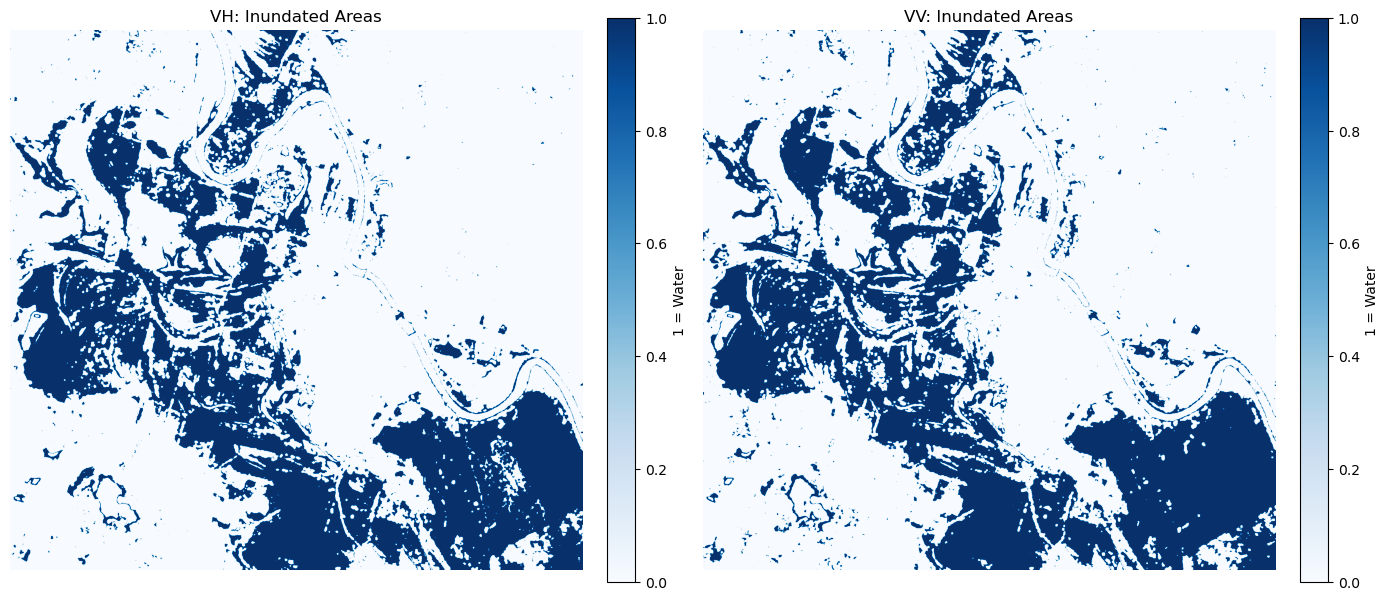

In [78]:
# Thresholds from your Otsu results
# Water masks (1 = water, 0 = non-water)
vh_before_mask = (vh_before_filt_dB < vh_threshold_otsu).astype(np.uint8)
vh_after_mask  = (vh_after_filt_dB < vh_threshold_otsu).astype(np.uint8)

vv_before_mask = (vv_before_filt_dB < vv_threshold_otsu).astype(np.uint8)
vv_after_mask  = (vv_after_filt_dB < vv_threshold_otsu).astype(np.uint8)

# VH new water = water after but not water before
vh_new_water = ((vh_after_mask == 1) & (vh_before_mask == 0)).astype(np.uint8)

# VV new water
vv_new_water = ((vv_after_mask == 1) & (vv_before_mask == 0)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# VH new water
im1 = axes[0].imshow(vh_new_water, cmap="Blues")
axes[0].set_title("VH: Inundated Areas")
axes[0].axis("off")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="1 = Water")

# VV new water
im2 = axes[1].imshow(vv_new_water, cmap="Blues")
axes[1].set_title("VV: Inundated Areas")
axes[1].axis("off")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="1 = Water")

plt.tight_layout()
plt.show()


### Create a flood map that shows inundation - VH

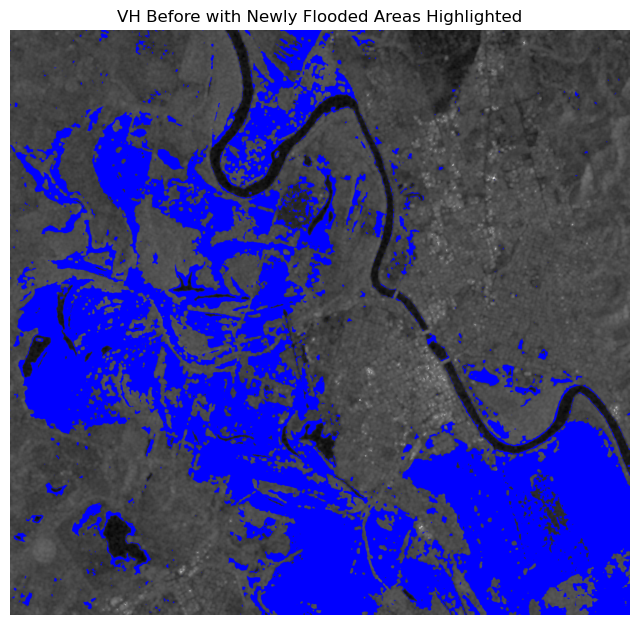

In [79]:
# another plot to show

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Example for VH
before_img = vh_before_filt_dB
new_water_mask = vh_new_water  # 1 = new water, 0 = no change

# Create an RGB image for plotting
rgb = np.stack([before_img, before_img, before_img], axis=-1)  # grayscale to RGB

# Normalize backscatter for display (0-1)
rgb_min, rgb_max = np.nanmin(before_img), np.nanmax(before_img)
rgb = (rgb - rgb_min) / (rgb_max - rgb_min)

# Highlight new water in blue
rgb[new_water_mask == 1] = [0, 0, 1]  # set RGB to pure blue

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("VH Before with Newly Flooded Areas Highlighted")
plt.axis("off")
plt.show()


### Create flood map with both existing water and flooded water for VH

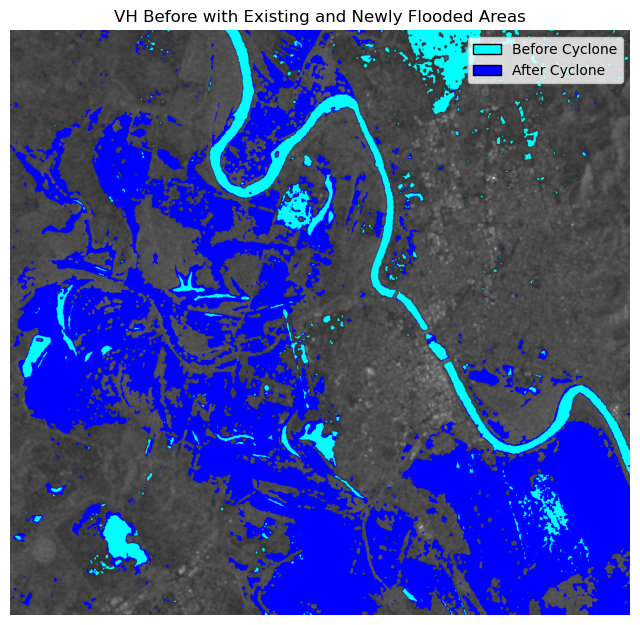

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# VH example
vh_before_img = vh_before_filt_dB
vh_new_water_mask = vh_new_water        # 1 = newly flooded
vh_before_water_mask = vh_before_mask   # 1 = water before (includes new water too)

# Create RGB image from grayscale
rgb = np.stack([before_img, before_img, before_img], axis=-1)

# Normalize backscatter to 0-1
rgb_min, rgb_max = np.nanmin(before_img), np.nanmax(before_img)
rgb = (rgb - rgb_min) / (rgb_max - rgb_min)

# Highlight existing water (before) in cyan
rgb[(vh_before_water_mask == 1) & (new_water_mask == 0)] = [0, 1, 1]

# Highlight newly flooded areas in blue
rgb[vh_new_water_mask == 1] = [0, 0, 1]

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("VH Before with Existing and Newly Flooded Areas")
plt.axis("off")

# Create legend patches
legend_elements = [
    Patch(facecolor='cyan', edgecolor='k', label='Before Cyclone'),
    Patch(facecolor='blue', edgecolor='k', label='After Cyclone')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

### Create flood map with both existing water and flooded water for VV

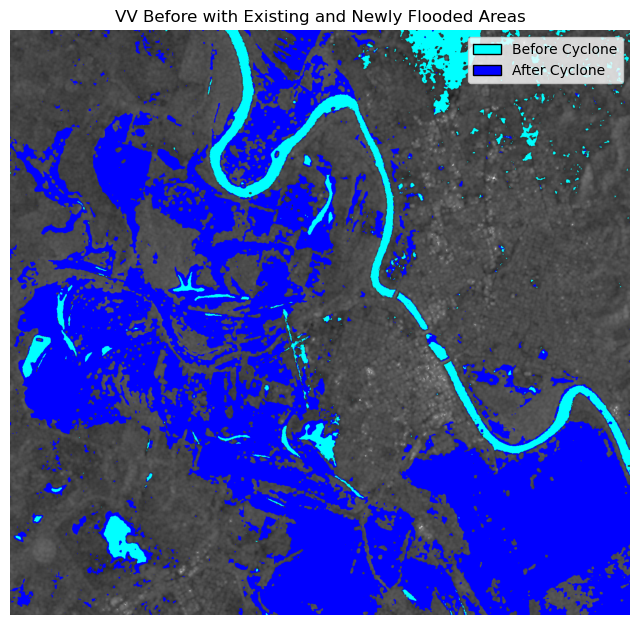

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

vv_before_img = vv_before_filt_dB
vv_new_water_mask = vv_new_water        # 1 = newly flooded
vv_before_water_mask = vv_before_mask   # 1 = water before (includes new water too)

# Create RGB image from grayscale
rgb = np.stack([before_img, before_img, before_img], axis=-1)

# Normalize backscatter to 0-1
rgb_min, rgb_max = np.nanmin(before_img), np.nanmax(before_img)
rgb = (rgb - rgb_min) / (rgb_max - rgb_min)

# Highlight existing water (before) in cyan
rgb[(vv_before_water_mask == 1) & (new_water_mask == 0)] = [0, 1, 1]

# Highlight newly flooded areas in blue
rgb[vv_new_water_mask == 1] = [0, 0, 1]

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("VV Before with Existing and Newly Flooded Areas")
plt.axis("off")

# Create legend patches
legend_elements = [
    Patch(facecolor='cyan', edgecolor='k', label='Before Cyclone'),
    Patch(facecolor='blue', edgecolor='k', label='After Cyclone')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

### Commit to Github

In [86]:
# Stage, commit, and push from notebook
!git add GEOM7001_Project/GEOM7001_SAR_Notebook.ipynb
!git commit -m "Add DEA Sandbox SAR flood mapping notebook"
!git push origin main

## CODE TO COMMIT AND PUSH EACH TIME
#git add <files>
#git commit -m "Message about changes"
#git push



fatal: not a git repository (or any parent up to mount point /home)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /home)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /home)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


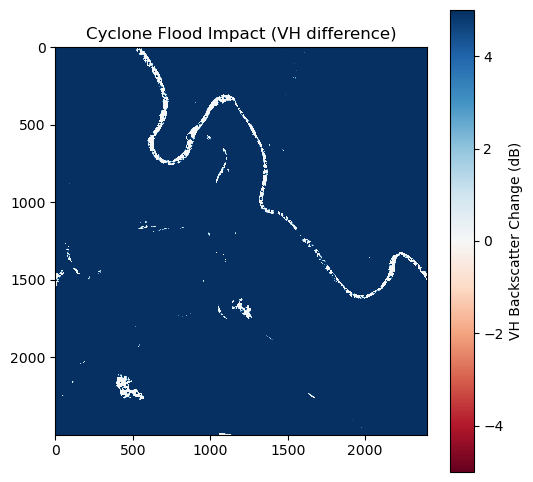

In [2]:
diff_vh = vh_after - vh_before
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(diff_vh, cmap="RdBu", vmin=-5, vmax=5)
plt.colorbar(label="VH Backscatter Change (dB)")
plt.title("Cyclone Flood Impact (VH difference)")
plt.show()
